### This is an example on how to access open source Sentinel-2 data from the Earth Engine platform and prepare the data for trainining classification models, building a simple model and creating a submission file to be uploaded to Zindi for scoring using .ipynb notebook in Colab.

### Ground truth data are geographic point features stored in a .csv file. The study area is Nangarhar province (Afghanistan). The reference period in the example is April-May 2022.    

### The participants are encuraged to test different DL models, to assess which one(s) perform(s) better.



In [1]:
#import ee
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

In [2]:
import datetime
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
import numpy as np
from sklearn.impute import KNNImputer

### Data preparation

### Sentinel 2

In [3]:
import os
# assign directory
directory = 'D:/Data science/Sensing AI/03 GEO-AI Challenge for Cropland Mapping by ITU/sentinelmonthex'
 
# iterate over files in
# that directory
filedum = os.path.join(directory, os.listdir(directory)[0])
dummy = pd.read_csv(filedum)[['ID','Target']]
#i = 1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    temp = pd.read_csv(f)[['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9',]]
    temp.columns = ['B01', 'B11', 'B12', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B8A', 'B09']
    temp = temp.add_suffix(f'_{filename}')
    dummy = pd.concat([dummy, temp], axis=1)
    #i=i+1

In [4]:
dfs2 = dummy

## Feature Enginering

### Sentinel2Tranformer

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class Sentinel2Tranformer(BaseEstimator, TransformerMixin):
    def __init__(self,listdate=None):
        self.listdate = listdate
    def fit(self,X,y = None):
        return self
    def transform(self,X,y=None):
        spectral_indices = ["NDVI", "GNDVI", "EVI", "EVI2", "AVI", "BSI", "SI", "NDWI", "NDMI", "NPCRI","NDBI"]        
        for i in range(len(listdate)):
            b1 = X.filter(like = "B01").values[:,i]
            b2 = X.filter(like = "B02").values[:,i]
            b3 = X.filter(like = "B03").values[:,i]
            b4 = X.filter(like = "B04").values[:,i]
            b5 = X.filter(like = "B05").values[:,i]
            b6 = X.filter(like = "B06").values[:,i]
            b7 = X.filter(like = "B07").values[:,i]
            b8 = X.filter(like = "B08").values[:,i]
            b9 = X.filter(like = "B09").values[:,i]    
            b11 = X.filter(like = "B11").values[:,i]
            X[f'NDVI_{self.listdate[i]}'] = (b8 - b4) / (b8 + b4) 
            X[f'GNDVI_{self.listdate[i]}'] = (b8 - b3) / (b8 + b3)
            X[f'EVI_{self.listdate[i]}'] = 2.5 * (b8 - b4) / ((b8 + 6.0 * b4 - 7.5 * b2) + 1.0)
            X[f'EVI2_{self.listdate[i]}'] = 2.4 * (b8 - b4) / (b8 + b4 + 1.0)
            X[f'AVI_{self.listdate[i]}'] = (b8 * (1 - b4) * (b8 - b4))
            X[f'BSI_{self.listdate[i]}'] = ((b11 + b4) - (b8 + b2)) / ((b11 + b4) + (b8 + b2))
            X[f'SI_{self.listdate[i]}'] = ((1 - b2) * (1 - b3) * (1 - b4))    
            X[f'NDWI_{self.listdate[i]}'] = (b3 - b8) / (b3 + b8)
            X[f'NDMI_{self.listdate[i]}'] = (b8 - b11) / (b8 + b11)
            X[f'NPCRI_{self.listdate[i]}'] = (b4 - b2) / (b4 + b2) 
            X[f'NDBI_{self.listdate[i]}'] = (b11 - b8) / (b11 + b8)
        spectral_indices = ["NDVI", "GNDVI", "EVI", "EVI2", "AVI", "BSI", "SI", "NDWI", "NDMI", "NPCRI","NDBI"]        
        for i in spectral_indices:
            X[f'{i}_min'] = X.filter(regex = f'^{i}').min(axis = 1)
            X[f'{i}_max'] = X.filter(regex = f'^{i}').max(axis = 1)
            X[f'{i}_avg'] = X.filter(regex = f'^{i}').mean(axis = 1)
            X[f'{i}_std'] = X.filter(regex = f'^{i}').std(axis = 1) 
        return X

In [6]:
listdate = os.listdir(directory)
listdate = [s[0:7] for s in listdate]

In [ ]:
sent2T = Sentinel2Tranformer(listdate)
train = sent2T.fit_transform(dfs2)

In [8]:
locates = pd.read_csv("train_test_all.csv").drop(["Target"],axis = 1)

In [9]:
train_s2 = locates.set_index('ID').join(train.set_index('ID'),)

In [10]:
train_s2.to_csv("Sentinel2 dataset.csv")

### Sentinel 1

In [11]:
import os
# assign directory
directory = 'D:/Data science/Sensing AI/03 GEO-AI Challenge for Cropland Mapping by ITU/sentinel1monthex'
 
# iterate over files in
# that directory
filedum = os.path.join(directory, os.listdir(directory)[0])
dummy = pd.read_csv(filedum)[['ID','Target']]
#i = 1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    temp = pd.read_csv(f)[['VV', 'VH']]
    temp.columns = ['VV', 'VH']
    temp = temp.add_suffix(f'_{filename[:-4]}')
    dummy = pd.concat([dummy, temp], axis=1)
    #i=i+1

In [12]:
dfs1 =dummy 

In [13]:
class Sentinel1Tranformer(BaseEstimator, TransformerMixin):
    def __init__(self,listdate=None):
        self.listdate = listdate
    def fit(self,X,y = None):
        return self
    def transform(self,X,y=None):
        spectral_indices = ["NDVI", "GNDVI", "EVI", "EVI2", "AVI", "BSI", "SI", "NDWI", "NDMI", "NPCRI","NDBI"]        
        for i in range(len(listdate)):
            vv = dfs1.filter(like = "VV").values[:,i]
            vh = dfs1.filter(like = "VH").values[:,i]
            dfs1[f'rvi_{listdate[i][:-4]}'] = (4-vh)/(vv+vh)
            
        sen_list = ["rvi"]
        for i in sen_list:
            dfs1[f'{i}_min'] = dfs1.filter(regex = f'^{i}').min(axis = 1)
            dfs1[f'{i}_max'] = dfs1.filter(regex = f'^{i}').max(axis = 1)
            dfs1[f'{i}_avg'] = dfs1.filter(regex = f'^{i}').mean(axis = 1)
            dfs1[f'{i}_std'] = dfs1.filter(regex = f'^{i}').std(axis = 1) 
        return X

In [14]:
listdate = os.listdir(directory)
listdate = [s[0:7] for s in listdate]

In [15]:
sent1T = Sentinel1Tranformer(listdate)
train_s1 = sent1T.fit_transform(dfs1)

In [16]:
locates = pd.read_csv("train_test_all.csv").drop(["Target"],axis = 1)

In [17]:
train_s1 = locates.set_index('ID').join(train_s1.set_index('ID'),)

In [18]:
train_s1.to_csv("Sentinel1 dataset.csv")

### Training Models

In [5]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [6]:
SEED = 1942424

In [7]:
# Instantiating the model
model_rf = RandomForestClassifier(n_estimators= 1000,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 110,
 bootstrap= True, n_jobs=-1)
model_xgb = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.001, random_state=SEED, n_jobs=-1) 
model_cat = CatBoostClassifier(verbose=0, n_estimators=100,task_type="GPU", random_state=SEED) 

In [8]:
num_linear_processor = make_pipeline(
    StandardScaler(), KNNImputer(n_neighbors=3)
)
rf_pipeline = make_pipeline(num_linear_processor, model_rf)
xgb_pipeline = make_pipeline(num_linear_processor, model_xgb)
cat_pipeline = make_pipeline(num_linear_processor, model_cat)

estimators = [
    ('rf', rf_pipeline),
    ('xgb',xgb_pipeline)
    #('cat',cat_pipeline)
]
ens_rfxgb_pipeline = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=SEED)
)

estimators_2 = [
    ('rf', rf_pipeline),
    ('xgb',xgb_pipeline),
    ('cat',cat_pipeline)
]
ens_rfxgbcat_pipeline = StackingClassifier(
    estimators=estimators_2, final_estimator=LogisticRegression(random_state=SEED)
)

### Sentinel 2 Models

In [3]:
#train_data = pd.read_csv("90 dataset.csv", index_col = 'ID')
train_data = pd.read_csv("Sentinel2 dataset.csv", index_col = 'ID')
# Taarget=3 is real test data
train_data_real = train_data[train_data.Target!=3]
X = train_data_real.drop(['Target'], axis = 1)
y = train_data_real.Target

C:\Users\jwst2\AppData\Local\Temp\ipykernel_23152\108682341.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("90 dataset.csv", index_col = 'ID')
C:\Users\jwst2\AppData\Local\Temp\ipykernel_23152\108682341.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("Sentinel2 dataset.csv", index_col = 'ID')


In [ ]:
pipelines = [rf_pipeline, xgb_pipeline, xgb_pipeline, cat_pipeline, ens_rfxgb_pipeline, ens_rfxgbcat_pipeline]
models = ['Random Forest', 'XGBoost', 'CatBoost', 'RandomForestXGB', 'RandomForestXGBCatboost']
cv_mean = []
cv = KFold(n_splits=5)
for index, pipeline in enumerate(pipelines):
    mean = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).mean(),3)
    cv_mean.append(mean)
    std = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).std(),3)
    print(f"The cross validation score for the model {models[index]} is {mean} +/- {std}.")

The cross validation score for the model Random Forest is 0.935 +/- 0.022.
The cross validation score for the model XGBoost is 0.907 +/- 0.032.
The cross validation score for the model CatBoost is 0.907 +/- 0.032.
The cross validation score for the model RandomForestXGB is 0.936 +/- 0.037.
The cross validation score for the model RandomForestXGBCatboost is 0.933 +/- 0.021.


### Sentinel 1 Models

In [14]:
# Selecting the independent variables and the target variable
train_data = pd.read_csv("Sentinel1 dataset.csv", index_col = 'ID')
train_data_real = train_data[train_data.Target!=3]
train_data_real = train_data_real.dropna()
X = train_data_real.drop(['Target'], axis = 1)
y = train_data_real.Target

In [19]:
pipelines = [rf_pipeline, xgb_pipeline, xgb_pipeline, cat_pipeline, ens_rfxgb_pipeline, ens_rfxgbcat_pipeline]
models = ['Random Forest', 'XGBoost', 'CatBoost', 'RandomForestXGB', 'RandomForestXGBCatboost']
cv_mean = []
cv = KFold(n_splits=5)
for index, pipeline in enumerate(pipelines):
    mean = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).mean(),3)
    cv_mean.append(mean)
    std = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).std(),3)
    print(f"The cross validation score for the model {models[index]} is {mean} +/- {std}.")

The cross validation score for the model Random Forest is 0.88 +/- 0.024.
The cross validation score for the model XGBoost is 0.835 +/- 0.041.
The cross validation score for the model CatBoost is 0.835 +/- 0.041.
The cross validation score for the model RandomForestXGB is 0.895 +/- 0.054.
The cross validation score for the model RandomForestXGBCatboost is 0.875 +/- 0.029.


IndexError: list index out of range

### Sentinel 2 and Sentinel 1 

In [7]:
train_data_s1 = pd.read_csv("Sentinel1 dataset.csv", index_col = 'ID').drop(["Lat","Lon","Target"],axis = 1)
train_data_s2 = pd.read_csv("Sentinel2 dataset.csv", index_col = 'ID')
train_data = train_data_s2.join(train_data_s1)

C:\Users\jwst2\AppData\Local\Temp\ipykernel_29036\2363229263.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_s2 = pd.read_csv("Sentinel2 dataset.csv", index_col = 'ID')


In [8]:
train_data.isna().sum()

Lat                   0
Lon                   0
Target                0
B01_2019-02.csv       0
B11_2019-02.csv       0
                   ... 
rvi_202            2159
rvi_min             881
rvi_max             881
rvi_avg             881
rvi_std             881
Length: 1355, dtype: int64

In [9]:
train_data_real = train_data[train_data.Target!=3.0]
#train_data_real = train_data_real.dropna()
X = train_data_real.drop(['Target'], axis = 1)
y = train_data_real.Target

In [10]:
train_data_s1.shape

(3953, 112)

In [11]:
pipelines = [ens_rfxgb_pipeline]
models = ['RandomForestXGB']
cv_mean = []
cv = KFold(n_splits=5)
for index, pipeline in enumerate(pipelines):
    mean = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).mean(),3)
    cv_mean.append(mean)
    std = np.round(cross_val_score(estimator=pipeline, X=X, y=y,cv=cv,scoring='accuracy', n_jobs=-1).std(),3)
    print(f"The cross validation score for the model {models[index]} is {mean} +/- {std}.")

The cross validation score for the model RandomForestXGB is 0.931 +/- 0.021.


## Time Series Deep Learning Clssification Approach

In [12]:
from fastai.tabular.all import *
import torch
from tsai.all import *
import sklearn.metrics as skm
torch.cuda.device(1)

In [19]:
listdate  = np.arange(1, 53)

In [20]:
directory = 'D:/Data science/Sensing AI/03 GEO-AI Challenge for Cropland Mapping by ITU/sentinelmonthex'
 
# iterate over files in
# that directory
filedum = os.path.join(directory, os.listdir(directory)[0])
dummy = pd.read_csv(filedum)[['ID','Target']]
i = 1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    temp = pd.read_csv(f)[['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9',]]
    temp.columns = ['B01', 'B11', 'B12', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B8A', 'B09']
    temp = temp.add_suffix(f'_{i}')
    dummy = pd.concat([dummy, temp], axis=1)
    i=i+1

In [21]:
spectral_indices = ["NDVI", "GNDVI", "EVI", "EVI2", "AVI", "BSI", "SI", "NDWI", "NDMI", "NPCRI","NDBI"]        
for i in range(len(listdate)):
    b1 = dummy.filter(like = "B01").values[:,i]
    b2 = dummy.filter(like = "B02").values[:,i]
    b3 = dummy.filter(like = "B03").values[:,i]
    b4 = dummy.filter(like = "B04").values[:,i]
    b5 = dummy.filter(like = "B05").values[:,i]
    b6 = dummy.filter(like = "B06").values[:,i]
    b7 = dummy.filter(like = "B07").values[:,i]
    b8 = dummy.filter(like = "B08").values[:,i]
    b9 = dummy.filter(like = "B09").values[:,i]    
    b11 = dummy.filter(like = "B11").values[:,i]
    dummy[f'NDVI_{listdate[i]}'] = (b8 - b4) / (b8 + b4) 
    dummy[f'GNDVI_{listdate[i]}'] = (b8 - b3) / (b8 + b3)
    dummy[f'EVI_{listdate[i]}'] = 2.5 * (b8 - b4) / ((b8 + 6.0 * b4 - 7.5 * b2) + 1.0)
    dummy[f'EVI2_{listdate[i]}'] = 2.4 * (b8 - b4) / (b8 + b4 + 1.0)
    dummy[f'AVI_{listdate[i]}'] = (b8 * (1 - b4) * (b8 - b4))
    dummy[f'BSI_{listdate[i]}'] = ((b11 + b4) - (b8 + b2)) / ((b11 + b4) + (b8 + b2))
    dummy[f'SI_{listdate[i]}'] = ((1 - b2) * (1 - b3) * (1 - b4))    
    dummy[f'NDWI_{listdate[i]}'] = (b3 - b8) / (b3 + b8)
    dummy[f'NDMI_{listdate[i]}'] = (b8 - b11) / (b8 + b11)
    dummy[f'NPCRI_{listdate[i]}'] = (b4 - b2) / (b4 + b2) 
    dummy[f'NDBI_{listdate[i]}'] = (b11 - b8) / (b11 + b8)

In [22]:
dummy.shape

(3953, 1198)

In [23]:
dataset = dummy.set_index("ID")
y = dataset.Target

In [24]:
dataset

,Target,B01_1,B11_1,B12_1,B02_1,B03_1,B04_1,B05_1,B06_1,B07_1,...,GNDVI_52,EVI_52,EVI2_52,AVI_52,BSI_52,SI_52,NDWI_52,NDMI_52,NPCRI_52,NDBI_52
ID,,,,,,,,,,,,,,,,,,,,,
ID_SJ098E7S2SY9,0,0.08250,0.28790,0.28600,0.1158,0.14420,0.17200,0.19340,0.20460,0.20440,...,0.158326,0.059405,0.060055,0.008153,0.184838,0.509402,-0.158326,-0.156511,0.232711,0.156511
ID_CWCD60FGJJYY,0,0.01340,0.12830,0.08310,0.0236,0.04900,0.02970,0.07430,0.20140,0.23030,...,0.554393,0.345216,0.354308,0.055342,-0.019157,0.790182,-0.554393,0.105038,0.309168,-0.105038
ID_C20R2C0AYIT0,0,0.07780,0.31190,0.29560,0.1136,0.17260,0.23320,0.26180,0.28370,0.29290,...,0.245540,0.092499,0.098268,0.014073,0.124241,0.548962,-0.245540,-0.036319,0.271625,0.036319
ID_MMU0PFMDQ7FW,0,0.07250,0.26320,0.19380,0.0731,0.11760,0.14440,0.20100,0.23850,0.25510,...,0.304302,0.129110,0.134259,0.016170,0.115549,0.655134,-0.304302,-0.035160,0.271756,0.035160
ID_OGEL0LA7Y94S,0,0.01060,0.10030,0.09485,0.0159,0.03110,0.03900,0.05565,0.06540,0.07330,...,0.432694,0.286823,0.287432,0.050084,0.063097,0.664918,-0.432694,0.004075,0.241961,-0.004075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_6LVHE89NN5VE,3,0.09490,0.27325,0.23380,0.0859,0.12385,0.13365,0.18905,0.23160,0.24890,...,0.374024,0.142078,0.143377,0.013392,0.087070,0.751731,-0.374024,-0.006415,0.258451,0.006415
ID_M51GDSUBKS8Q,3,0.01710,0.17780,0.08590,0.0234,0.05600,0.02170,0.09810,0.38390,0.43770,...,0.324351,0.152065,0.159866,0.021064,0.148996,0.649601,-0.324351,-0.088286,0.282477,0.088286
ID_469MTLRKJC64,3,0.02305,0.20235,0.11480,0.0325,0.07770,0.05850,0.12775,0.31305,0.34885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
y

ID
ID_SJ098E7S2SY9    0
ID_CWCD60FGJJYY    0
ID_C20R2C0AYIT0    0
ID_MMU0PFMDQ7FW    0
ID_OGEL0LA7Y94S    0
                  ..
ID_6LVHE89NN5VE    3
ID_M51GDSUBKS8Q    3
ID_469MTLRKJC64    3
ID_DMH9P3N6O3DK    3
ID_FKB2YZ2BXZ0Z    3
Name: Target, Length: 3953, dtype: int64

In [246]:

col = dataset.columns
idx = dataset.index
dataset = num_linear_processor.fit_transform(dataset) 
dataset = pd.DataFrame(dataset)
dataset.columns = col


In [247]:
dataset

,Target,B01_1,B11_1,B12_1,B02_1,B03_1,B04_1,B05_1,B06_1,B07_1,...,GNDVI_52,EVI_52,EVI2_52,AVI_52,BSI_52,SI_52,NDWI_52,NDMI_52,NPCRI_52,NDBI_52
0,-1.133766,0.634079,0.701110,1.097627,0.757387,0.520851,0.540057,0.432577,-0.367313,-0.603949,...,-1.148154,-0.876049,-0.916702,-0.697367,0.925054,-0.954147,1.148154,-1.267703,-0.636682,1.267703
1,-1.133766,-1.521485,-1.568983,-1.433967,-1.364813,-1.434324,-1.621162,-1.698698,-0.422377,-0.238439,...,1.137601,0.999234,0.994656,0.510208,-0.790573,1.074640,-1.137601,0.786065,0.051745,-0.786065
2,-1.133766,0.487463,1.042478,1.217407,0.706749,1.104118,1.469549,1.656584,0.993789,0.644995,...,-0.644836,-0.658911,-0.668486,-0.545879,0.415426,-0.668307,0.644836,-0.323914,-0.286294,0.323914
3,-1.133766,0.322131,0.349786,-0.052757,-0.225454,-0.025448,0.120875,0.568578,0.216016,0.111548,...,-0.305712,-0.418696,-0.434703,-0.492217,0.342328,0.098841,0.305712,-0.314815,-0.285120,0.314815
4,-1.133766,-1.608830,-1.967245,-1.287362,-1.542047,-1.801947,-1.479916,-2.032436,-2.762578,-2.454080,...,0.435260,0.616100,0.560255,0.375663,-0.098806,0.169535,-0.435260,-0.006725,-0.553389,0.006725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,1.216405,1.020895,0.492734,0.446325,0.069168,0.102912,-0.042394,0.354735,0.097286,0.024051,...,0.096666,-0.333608,-0.375476,-0.563296,0.102816,0.796808,-0.096666,-0.089101,-0.404912,0.089101
3949,1.216405,-1.406064,-0.864913,-1.399031,-1.369417,-1.290561,-1.742664,-1.272801,2.717967,2.688466,...,-0.190003,-0.268087,-0.268365,-0.366976,0.623624,0.058864,0.190003,-0.731975,-0.188582,0.731975
3950,1.216405,-1.220454,-0.515722,-1.038444,-1.159959,-0.844896,-1.183754,-0.742219,1.498825,1.434582,...,0.127008,-0.067375,-0.047989,-0.210066,0.603207,0.197169,-0.127008,-0.697565,-0.029052,0.697565
3951,1.216405,-0.919424,-1.103870,-1.184426,-0.844621,-0.998928,-0.916450,-0.948904,-0.615099,-0.455769,...,0.791910,0.748535,0.763294,0.489579,-0.455497,0.998218,-0.791910,0.424791,0.208849,-0.424791


In [ ]:
pd.to_csv("timeseries dataset s2.csv")

### Models

In [271]:
all_l = ['B01', 'B11', 'B12', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B8A', 'B09',"NDVI", "GNDVI", "EVI", "EVI2", "AVI", "BSI", "SI", "NDWI", "NDMI", "NPCRI","NDBI"]

keep_l = ['B02', 'B03', 'B04']
remove_l = set(all_l).symmetric_difference(set(remove_l))

In [272]:
dataset = pd.read_csv("timeseries dataset s2.csv")
#dataset = dataset.drop(["Lon","Lat"],axis =1)


In [273]:
for text in remove_l: 
    dataset = dataset[dataset.columns.drop(list(dataset.filter(like=text)))]

In [274]:
dataset_time = pd.wide_to_long(dataset,list(keep_l), i=['ID'], j='month',
                    sep='_')

In [275]:
dataset_time_train = dataset_time[dataset_time.Target!=3]
dataset_time_test = dataset_time[dataset_time.Target!=3]
X = dataset_time_train.drop(['Target'], axis = 1).fillna(0)
y = dataset.Target[dataset.Target!=3].astype("category")

In [276]:
X = X.to_numpy().reshape(2453,len(keep_l),52)

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [278]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [279]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [280]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,  num_workers=0)

In [281]:
dls

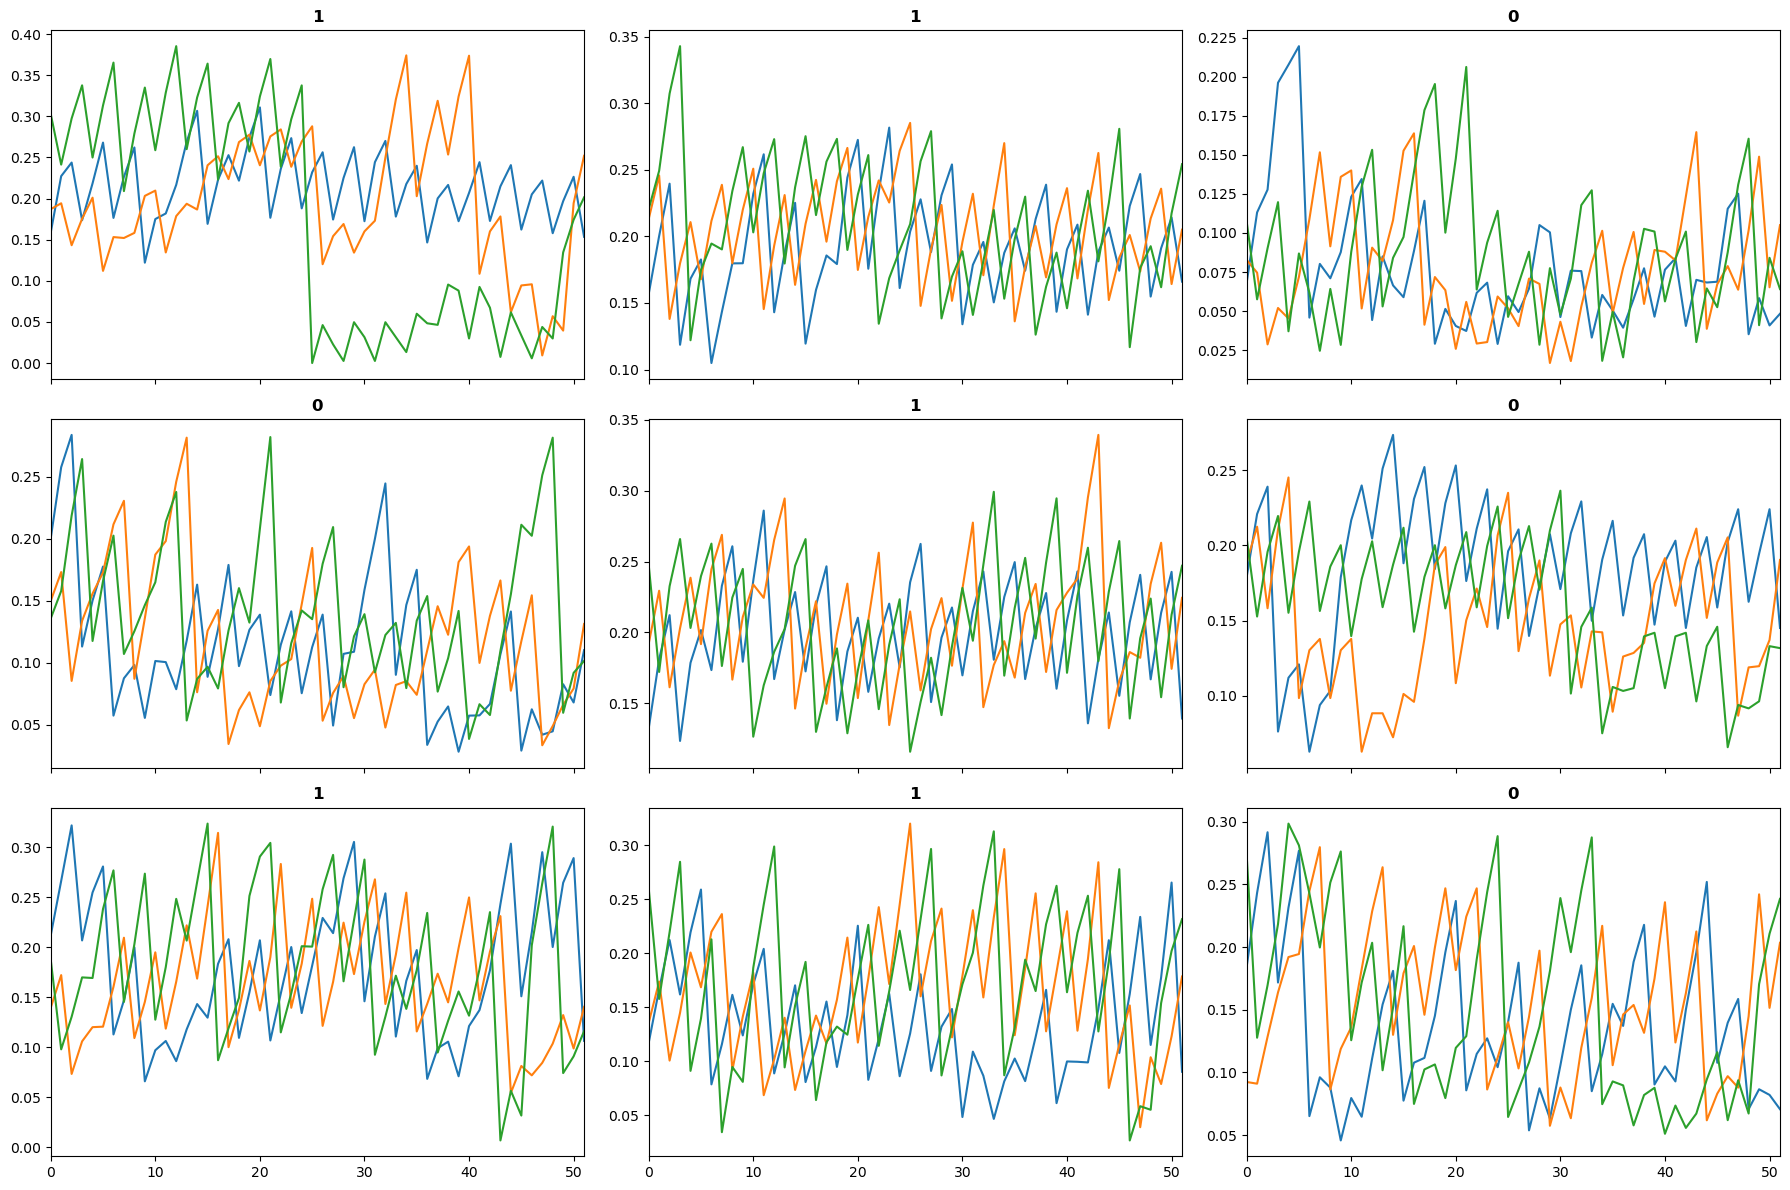

In [282]:
dls.show_batch()

In [283]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)


SuggestedLRs(valley=0.005248074419796467)

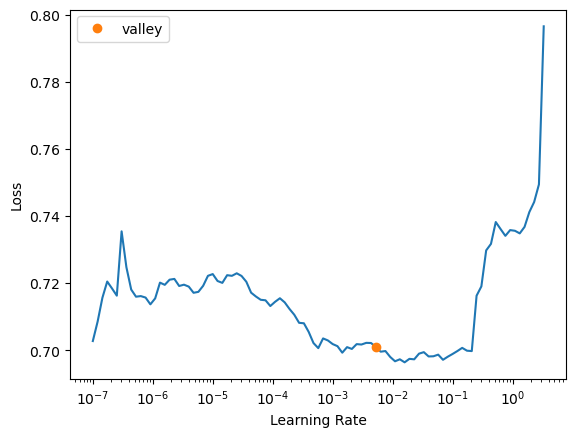

In [284]:
learn.lr_find()

In [285]:
learn.fit_one_cycle(49, lr_max=0.0001)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.722775,0.699326,0.505435,00:04
1,0.708513,0.702234,0.513587,00:04
2,0.695983,0.680209,0.570652,00:04
3,0.683796,0.674574,0.570652,00:04
4,0.672549,0.682432,0.581522,00:03
5,0.658333,0.667411,0.584239,00:04
6,0.644613,0.663863,0.593750,00:03
7,0.625454,0.669518,0.582880,00:04
8,0.601066,0.801947,0.543478,00:04
9,0.567685,0.760235,0.567935,00:04


Path('models/stage1.pth')

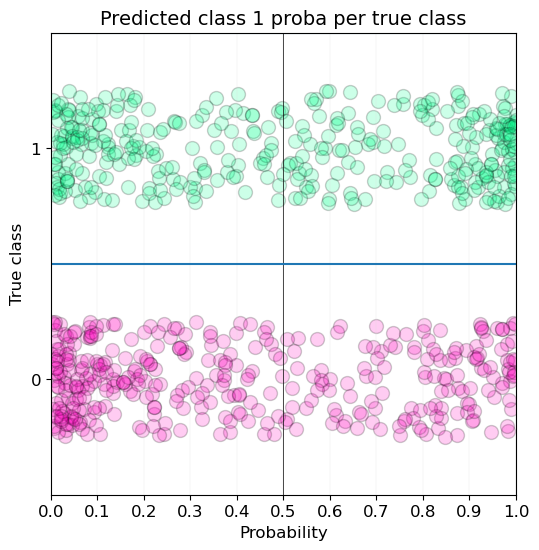

In [286]:
learn.show_probas()

In [287]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [288]:
del learn, dsets, dls

In [64]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:64, vars:52, len:23, device=cuda:0, dtype=torch.float32),
 TensorCategory([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
                 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
                 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
                 0], device='cuda:0'))

In [66]:
dataset_time_test = dataset_time[dataset_time.Target==3]
X_sub = dataset_time_test.drop(['Target'], axis = 1).fillna(0)
y_sub = dataset[dataset.Target==3].astype("category")
y_sub.Target = 0

In [67]:
y_sub = y_sub.Target

In [68]:
X_sub = X_sub.to_numpy().reshape(1500,52,23)

In [69]:
probas, se, preds = learn.get_X_preds(X_sub)

In [71]:
test = dataset[dataset.Target==3].astype("category")

In [72]:
probas[:,1]

tensor([0.0550, 0.0015, 0.9924,  ..., 0.9900, 0.0214, 0.9235])

In [87]:
test = test.drop(['Target'], axis = 1)
test["Target"] = (probas[:,1] >0.5).long()

In [88]:
fin  = test[['ID','Target']]

In [89]:
fin.to_csv("sub_21.csv", index = False)

In [90]:
fin

,ID,Target
1,ID_00SYEM165IJF,0
2,ID_01BG454IZX6G,0
3,ID_01EJ4DR99B1E,1
5,ID_01NLOAIAX2Q8,1
6,ID_01Q885IGNM20,1
...,...,...
2993,ID_ZYGY6FFVUCXW,1
2994,ID_ZYJJ32XRHM1I,1
2996,ID_ZYYYWNDJ43YS,1
2997,ID_ZZOSGGAB4PUY,0


### Prediction for submission

In [13]:
def makeSubmission(model,test, path):
    # # Create a submission file
    predictions = model.predict(test)
    sub_file = pd.DataFrame({'ID': test_data.index, 'Target': predictions})
    sub_file.to_csv(path, index = False)

In [10]:
ens_rfxgb_pipeline.fit(X,y)

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('knnimputer',
                                                                  KNNImputer(n_neighbors=3))])),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(max_depth=110,
                                                                        n_estimators=1000,
                                                                        n_jobs=-1))])),
                               ('xgb',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('knni...
                                                               interaction_constraints=None,
                                                               learning_rate=0.001,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=1000,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=1942424, ...))]))],
                   final_estimator=LogisticRegression(random_state=1942424))

In [19]:
test_data = train_data[train_data.Target==3]

In [20]:
test_data.drop(["Target"],axis =1,inplace =True)

C:\Users\jwst2\AppData\Local\Temp\ipykernel_23152\569405336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(["Target"],axis =1,inplace =True)


In [22]:
makeSubmission(ens_rfxgb_pipeline,test_data,"rfxgb_sub.csv")